In [414]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from skimage import data
from skimage.color import rgb2gray
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from skimage import data, exposure
import pandas as pd
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.optimizers import RMSprop

In [415]:
# Caricamento del Dataset
classesName = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [416]:
# Divisione con insieme di validazione formato dal % del train
percentuale = 0.1
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=percentuale, random_state=1)

In [417]:
# Normalizzazione in 0-1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0

In [418]:
############################################################################################

In [419]:
# Dimensioni Train
print("Dimensioni train : " , x_train.shape)
print ("Dimensioni etichette_train : " , y_train.shape)

Dimensioni train :  (45000, 32, 32, 3)
Dimensioni etichette_train :  (45000, 1)


In [420]:
# Dimensioni Validation
print("Dimensioni validation : " , x_val.shape)
print ("Dimensioni etichette_val : " , y_val.shape)

Dimensioni validation :  (5000, 32, 32, 3)
Dimensioni etichette_val :  (5000, 1)


In [421]:
# Dimensioni Test
print("Dimensioni test : " , x_test.shape)
print ("Dimensioni etichette_test : " , y_test.shape)

Dimensioni test :  (10000, 32, 32, 3)
Dimensioni etichette_test :  (10000, 1)


In [422]:
############################################################################################

In [423]:
# Stampa dei possibili valori delle etichette e del numero di volte che si ripetono nel Train
print("Numero di valori per ogni etichetta in train: ")
np.unique(y_train, return_counts = True)

Numero di valori per ogni etichetta in train: 


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([4490, 4508, 4485, 4526, 4470, 4502, 4499, 4511, 4519, 4490],
       dtype=int64))

In [424]:
# Stampa dei possibili valori delle etichette e del numero di volte che si ripetono nel Validation
print("Numero di valori per ogni etichetta in train: ")
np.unique(y_val, return_counts = True)

Numero di valori per ogni etichetta in train: 


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([510, 492, 515, 474, 530, 498, 501, 489, 481, 510], dtype=int64))

In [425]:
# Stampa dei possibili valori delle etichette e del numero di volte che si ripetono nel test
print("Numero di valori per ogni etichetta in test : ")
np.unique(y_test, return_counts = True)

Numero di valori per ogni etichetta in test : 


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000],
       dtype=int64))

In [426]:
######################################################################################
###################### -- PANDAS DF -- ###############################################
######################################################################################

# Riduzione di dimensionalità x train
##  print(" - Creazione Df x train - ")

# -1 -> numero righe finali impostato in automatico
# 3072 -> numero colonne che deriva da 32*32*3
# - in questo modo ogni riga corrisponde a un'immagine e ogni colonna il valore di un pixel in un'unico canale colore
x_train_flat = x_train.reshape(-1,3072)

# Creazione di una lista di nomi di pixel dal primo all'ultimo che compone un'immagine
# - utile in seguito in modo da assegnare nome a colonne del Data Frame Pandas
feat_cols = ['pixel'+str(i) for i in range(x_train_flat.shape[1])]

# Creazione del dataframe pandas
df_cifar = pd.DataFrame(x_train_flat,columns=feat_cols)

##  print("Shape di df_cifar : ")
##  print(df_cifar.shape)
##  print("")

# Assegnazione delle etichette ai valori nel dataframe
df_cifar['label'] = y_train

##  print("Shape del df_cifar dopo aggiunta etichette : ")
##  print(df_cifar.shape)




In [427]:
################################################################################

# Riduzione di dimensionalità x val
##  print("Creazione Df x val")
x_val_flat = x_val.reshape(-1,3072)

# Creazione di una lista di nomi di pixel dal primo all'ultimo che compone un'immagine
feat_cols_val = ['pixel'+str(i) for i in range(x_val_flat.shape[1])]

##  print("")

# Creazione del dataframe
df_cifar_val = pd.DataFrame(x_val_flat,columns=feat_cols_val)
##  print("Shape del df_cifar_val : ")
##  print(df_cifar_val.shape)

##  print("")

# Assegnazione delle etichette ai valori nel dataframe
df_cifar_val['label'] = y_val
##  print("Shape del df_cifar_val con etichette : ")
##  print(df_cifar_val.shape)

In [428]:
# Riduzione di dimensionalità x test
##  print("Creazione Df x test")

x_test_flat = x_test.reshape(-1,3072)


# Creazione di una lista di nomi di pixel dal primo all'ultimo che compone un'immagine
feat_cols_test = ['pixel'+str(i) for i in range(x_test_flat.shape[1])]

##  print("")

# Creazione del dataframe
df_cifar_test = pd.DataFrame(x_test_flat,columns=feat_cols_test)
##  print("Shape di df_cifar_test : ")
##  print(df_cifar_test.shape)

##  print("")

# Assegnazione delle etichette ai valori nel dataframe
df_cifar_test['label'] = y_test
##  print("Shape del df_cifar_test con etichette : ")
##  print(df_cifar_test.shape)

In [429]:
################################################################################

# Utilizzo di PCA su TRAIN

# n_components è il numero di componenti che vogliamo valutare come obiettivo
pca_train = PCA(n_components=2)

# Estrazione di tutti i dati tranne ultima colonna che contiene le etichette
# - principalComponents_cifar è il risultato della riduzione di dimensionalità
principalComponents_cifar = pca_train.fit_transform(df_cifar.iloc[:,:-1])

################################################################################

# Utilizzo di PCA su TEST

pca_test = PCA(n_components=2)


# Estrazione di tutti i dati tranne ultima colonna che contiene le etichette
# - principalComponents_cifar è il risultato della riduzione di dimensionalità
principalComponents_cifar_test = pca_test.fit_transform(df_cifar_test.iloc[:,:-1])

################################################################################

# Utilizzo di PCA su VAL

pca_val = PCA(n_components=2)


# Estrazione di tutti i dati tranne ultima colonna che contiene le etichette
# - principalComponents_cifar è il risultato della riduzione di dimensionalità
principalComponents_cifar_val = pca_val.fit_transform(df_cifar_val.iloc[:,:-1])


In [430]:
################################################################################

##  print("Assegnazione nome colonne a DF ottenuto x TRAIN")

# DF = Data Frame

# Creazione di nuovo data frame
# - partendo da quello appena ottenuto
# - vengono aggiunti i nomi dei valori contenuti
pca_cifar_Df = pd.DataFrame(data = principalComponents_cifar, columns = ['principal component 1', 'principal component 2'])

##  print("")

# Aggiunta della colonna con le etichette dei dati relativi
# - Lo faccio in una copia del dataframe così da averne uno senza etichette
##  print("Creazione dataframe con etichette come ultima colonna")
pca_cifar_Df_con_etichette = pca_cifar_Df.copy()
pca_cifar_Df_con_etichette['y'] = y_train

##  print("")

# - STAMPE DI SERVIZIO - # 
# Stampa del nuovo DF
#print("Shape del DF risultato :")
#print(principal_cifar_Df.shape)

#print("")

# Stampa delle prime righe del DF
#print("Head di principal_cifar_Df : ")
#principal_cifar_Df.head()

#print("Shape del DF_etichettato risultato :")
#print(principal_cifar_Df_con_etichette.shape)

#print("")

# Stampa delle prime righe del DF
#print("Head di principal_cifar_Df_etichettato : ")
#principal_cifar_Df_con_etichette.head()

In [431]:
################################################################################

print("Assegnazione nome colonne a DF ottenuto x TEST")

# DF = Data Frame

# Creazione di nuovo data frame
# - partendo da quello appena ottenuto
# - vengono aggiunti i nomi dei valori contenuti
pca_cifar_Df_test = pd.DataFrame(data = principalComponents_cifar_test, columns = ['principal component 1', 'principal component 2'])

print("")

# Aggiunta della colonna con le etichette dei dati relativi
# - Lo faccio in una copia del dataframe così da averne uno senza etichette
print("Creazione dataframe con etichette come ultima colonna x test")
pca_cifar_Df_con_etichette_test = pca_cifar_Df_test.copy()
pca_cifar_Df_con_etichette_test['y'] = y_test

# - STAMPE DI SERVIZIO - # 
# Stampa del nuovo DF_test
#print("Shape del DF risultato :")
#print(principal_cifar_Df_test.shape)

#print("")

# Stampa delle prime righe del DF
#print("Head di principal_cifar_Df : ")
#principal_cifar_Df_test.head()

# Stampa del nuovo DF
#print("Shape del Df ottenuto x test :")
#print(principal_cifar_Df_con_etichette_test.shape)

#print("")

# Stampa delle prime righe del DF
#principal_cifar_Df_con_etichette_test.head()

Assegnazione nome colonne a DF ottenuto x TEST

Creazione dataframe con etichette come ultima colonna x test


In [432]:
################################################################################

print("Assegnazione nome colonne a DF ottenuto x val")

# DF = Data Frame

# Creazione di nuovo data frame
# - partendo da quello appena ottenuto
# - vengono aggiunti i nomi dei valori contenuti
pca_cifar_Df_val = pd.DataFrame(data = principalComponents_cifar_val, columns = ['principal component 1', 'principal component 2'])

print("")

# Aggiunta della colonna con le etichette dei dati relativi
# - Lo faccio in una copia del dataframe così da averne uno senza etichette
print("Creazione dataframe con etichette come ultima colonna x val")
pca_cifar_Df_con_etichette_val = pca_cifar_Df_val.copy()
pca_cifar_Df_con_etichette_val['y'] = y_val

# - STAMPE DI SERVIZIO - #
# Stampa del nuovo DF_val
#print("Shape del DF risultato :")
#print(principal_cifar_Df_val.shape)

#print("")

# Stampa delle prime righe del DF
#print("Head di principal_cifar_Df : ")
#principal_cifar_Df_val.head()

# Stampa del nuovo DF
#print("Shape del Df ottenuto x val :")
#print(principal_cifar_Df_con_etichette_val.shape)

#print("")

# Stampa delle prime righe del DF
#principal_cifar_Df_con_etichette_val.head()

Assegnazione nome colonne a DF ottenuto x val

Creazione dataframe con etichette come ultima colonna x val


In [433]:
################################################################################
### STAMPA VARIANZA ############################################################
################################################################################

# Stampa della varianza memorizzata all'interno delle componenti selezionate da PCA
print('Varianza delle componenti selezionate DF train : {}'.format(pca_train.explained_variance_ratio_))

# Stampa della varianza memorizzata all'interno delle componenti selezionate da PCA_val
print('Varianza delle componenti selezionate in DF val : {}'.format(pca_val.explained_variance_ratio_))

# Stampa della varianza memorizzata all'interno delle componenti selezionate da PCA_test
print('Varianza delle componenti selezionate in DF test : {}'.format(pca_test.explained_variance_ratio_))

Varianza delle componenti selezionate DF train : [0.2908679  0.11252237]
Varianza delle componenti selezionate in DF val : [0.2900313  0.11280391]
Varianza delle componenti selezionate in DF test : [0.29161647 0.10896881]


Grafico distribuizione valori di TRAIN



C:\Users\domen\AppData\Local\Temp\ipykernel_18028\2317683120.py:7: UserWarning: The palette list has more values (13) than needed (10), which may not be intended.
  sns.scatterplot(


<Axes: xlabel='principal component 1', ylabel='principal component 2'>

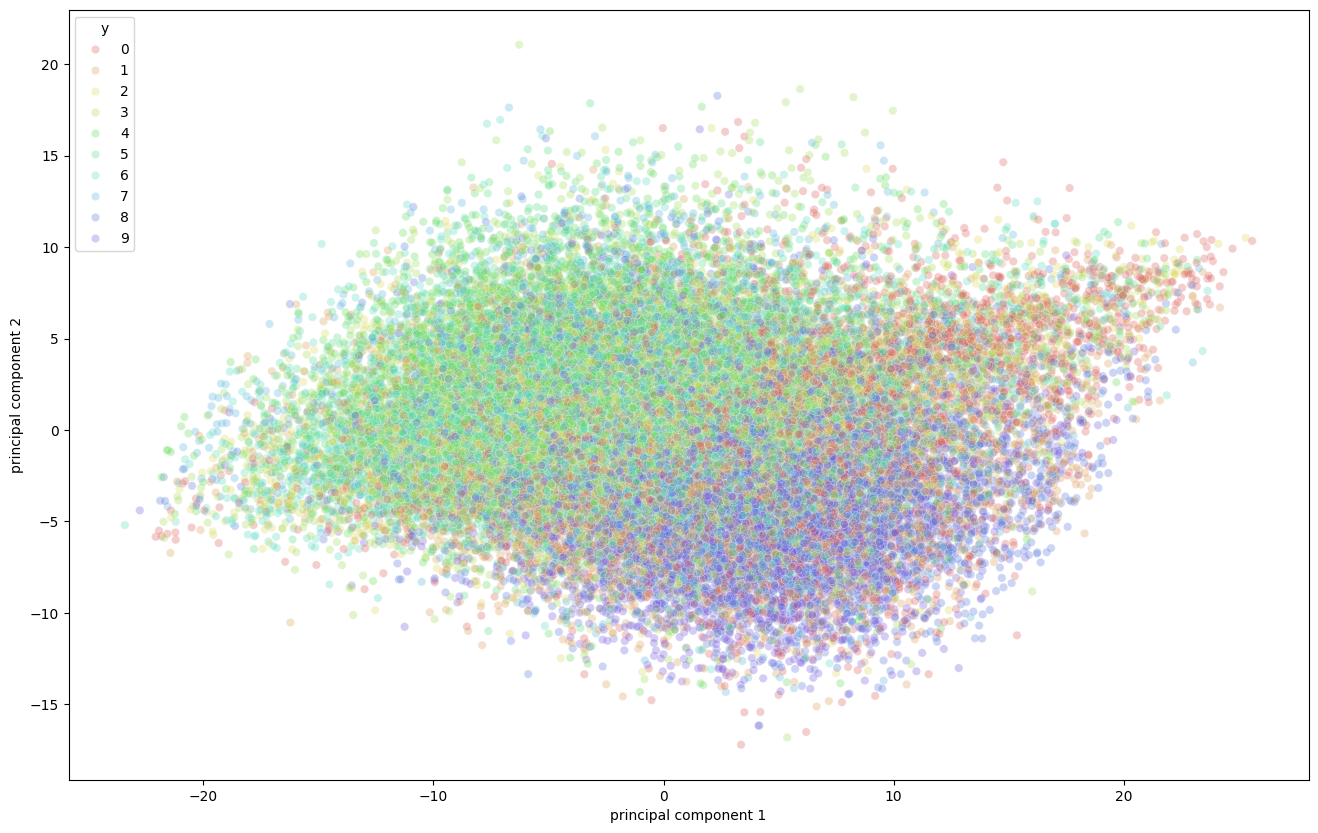

In [434]:
print("Grafico distribuizione valori di TRAIN")

print("")

import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="y",
    palette=sns.color_palette("hls", 13),
    data=pca_cifar_Df_con_etichette,
    legend="full",
    alpha=0.3
)

Grafico distribuizione valori di TEST



<Axes: xlabel='principal component 1', ylabel='principal component 2'>

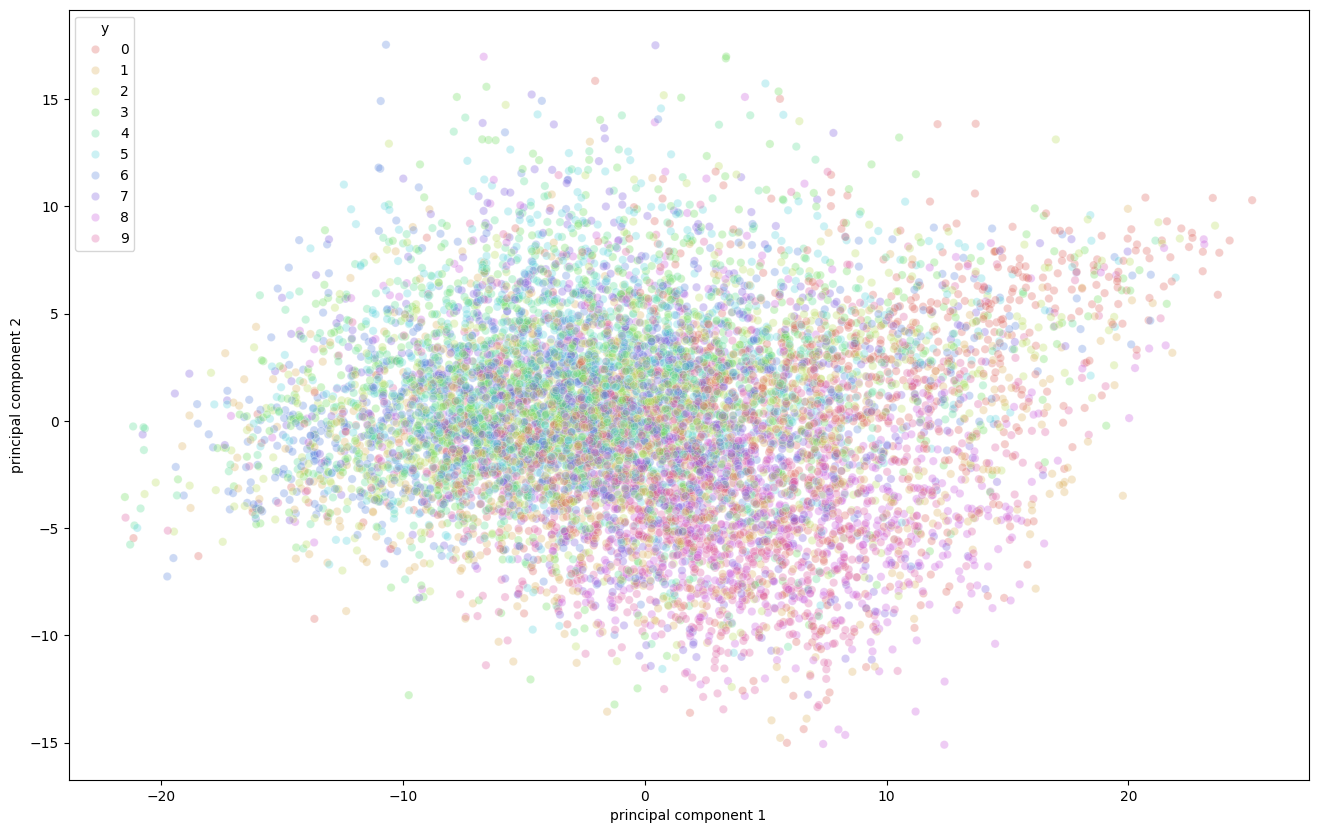

In [435]:
print("Grafico distribuizione valori di TEST")

print("")

import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pca_cifar_Df_con_etichette_test,
    legend="full",
    alpha=0.3
)

Grafico distribuizione valori di val



C:\Users\domen\AppData\Local\Temp\ipykernel_18028\2721250616.py:7: UserWarning: The palette list has more values (13) than needed (10), which may not be intended.
  sns.scatterplot(


<Axes: xlabel='principal component 1', ylabel='principal component 2'>

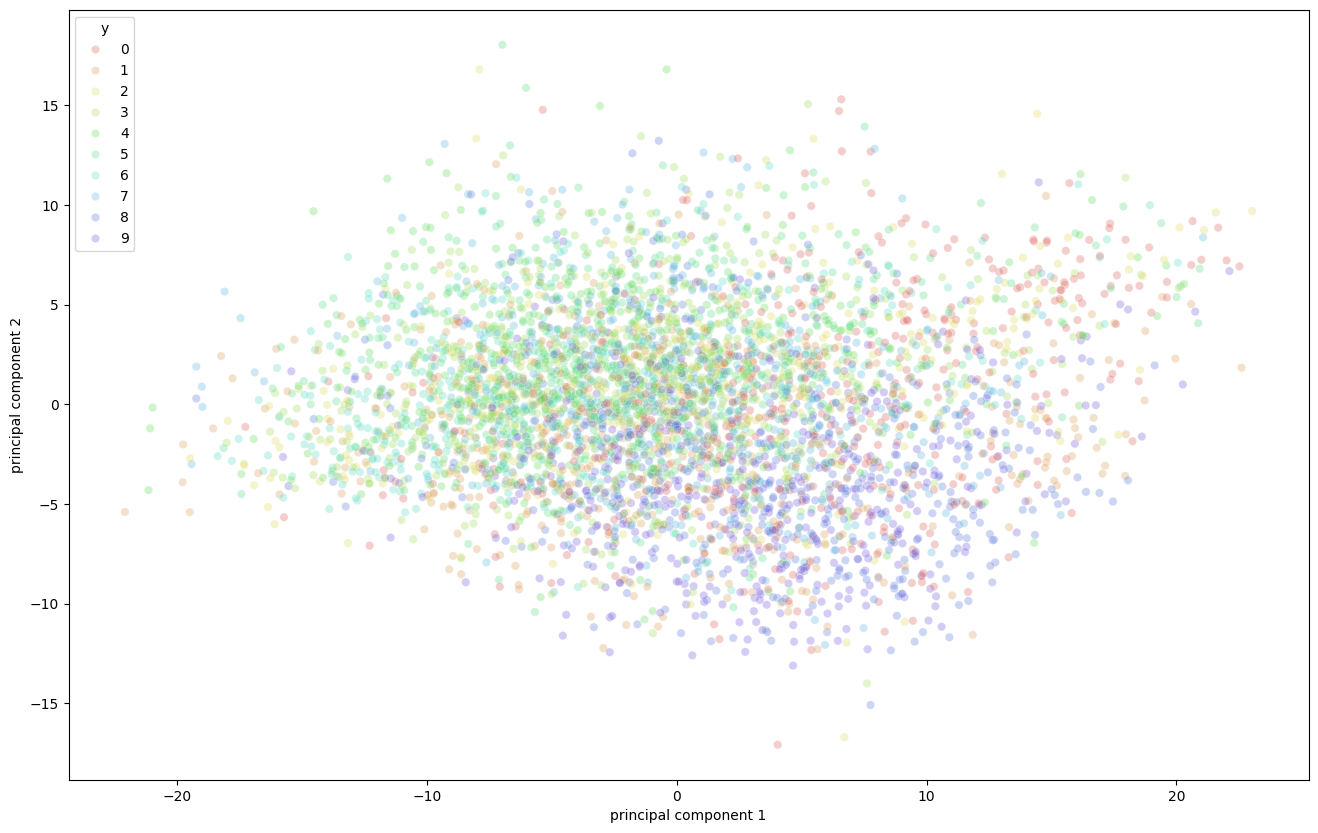

In [436]:
print("Grafico distribuizione valori di val")

print("")

import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="y",
    palette=sns.color_palette("hls", 13),
    data=pca_cifar_Df_con_etichette_val,
    legend="full",
    alpha=0.3
)

In [401]:
# Ora ho capito comme ridurre la dimensionalità del dataset posso fare operazioni di classificazione con SVM ?

In [402]:
'''
##############################################
## - APPROCCIO CON MODELLO TROVATO ONLINE - ##
###################################################################################
# -> https://www.datacamp.com/tutorial/principal-component-analysis-in-python <- ##
###################################################################################
# - Utilizzo di una NN sequenziale - #########
###############################################################################
# - Senza scremare il dataset il risultato della classificazione è inutile - ##
###############################################################################


# Imposto PCA in modo che mantenga il 90% della varianza originale
pca = PCA(0.9)

# Adattamento dei dati in modo che mantengano le caratteristiche desiderate
pca.fit(x_train_flat)

# Creazione dell'oggetto PCA con i parametri desiderati
PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

# Stampa dei componenti individuati in fase di riduzione della dimensionalità
print("Numero caratteristiche individuate : ",pca.n_components_)

# Applico trasformazione a dati in modo da proiettarli su uno spazio di dimensionalità ridotta
# - Ottenuto prima
train_img_pca = pca.transform(x_train_flat)
test_img_pca = pca.transform(x_test_flat)

print("")
print("Shape delle dimensioni del risultato dei dati di train : ",train_img_pca.shape)
print("Shape delle dimensioni del risultato dei dati di test : ",test_img_pca.shape)
print("")

# Vettore delle etichette creato come vettore one-shot
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Numero di elementi da utilizzare per aggiornamento pesi
batch_size = 128 #512 #128

# Numero di classi da classificare
num_classes = 10

# Epoche su cui basare l'apprendimento
epochs = 20

# Definizione degli strati della rete
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(99,)))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Stampa della conformazione del modello
model.summary()

# Assemblaggio del modello
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
# Esecuzione allenamento e calcolo affidabilità
history = model.fit(train_img_pca, y_train,batch_size=batch_size,epochs=epochs,verbose=1,
                    validation_data=(test_img_pca, y_test))
'''


'\n##############################################\n## - APPROCCIO CON MODELLO TROVATO ONLINE - ##\n###################################################################################\n# -> https://www.datacamp.com/tutorial/principal-component-analysis-in-python <- ##\n###################################################################################\n# - Utilizzo di una NN sequenziale - #########\n###############################################################################\n# - Senza scremare il dataset il risultato della classificazione è inutile - ##\n###############################################################################\n\n\n# Imposto PCA in modo che mantenga il 90% della varianza originale\npca = PCA(0.9)\n\n# Adattamento dei dati in modo che mantengano le caratteristiche desiderate\npca.fit(x_train_flat)\n\n# Creazione dell\'oggetto PCA con i parametri desiderati\nPCA(copy=True, iterated_power=\'auto\', n_components=0.9, random_state=None,\n  svd_solver=\'auto\', tol=

In [403]:
'''
# CLASSIFICAZIONE con Random Forest su tutto training set
# - Senza scremare il dataset il risultato è inutilizzabile e non classificabile

# Train
# - ExtraTreesClassifier è una versione alternativa di RF dove viene introdotto un fattore di casualità che potrebbe migliorare i risultati che si ottengono
from sklearn.ensemble import ExtraTreesClassifier

# clf -> classifier
# - n_estimators -> numero di alberi decisionali utilizzati
# - - ho fatto varie prove partendo da 100, un numero minore di 9 porta a problemi nelle predizioni
# - random_state -> seme per il valore casuale che verrà utilizzato, utile a aumentare la riproducibilità dell'algoritmo
clf = ExtraTreesClassifier(n_estimators=10, random_state=19)

clf.fit(pca_cifar_Df, y_train)

# Test di RF
training_error_RF = 1. - clf.score(pca_cifar_Df, y_train)
test_error = 1. - clf.score(pca_cifar_Df_test, y_test)


print ("RF training error: %f" % training_error_RF)
print ("RF test error: %f" % test_error)
'''

'\n# CLASSIFICAZIONE con Random Forest su tutto training set\n# - Senza scremare il dataset il risultato è inutilizzabile e non classificabile\n\n# Train\n# - ExtraTreesClassifier è una versione alternativa di RF dove viene introdotto un fattore di casualità che potrebbe migliorare i risultati che si ottengono\nfrom sklearn.ensemble import ExtraTreesClassifier\n\n# clf -> classifier\n# - n_estimators -> numero di alberi decisionali utilizzati\n# - - ho fatto varie prove partendo da 100, un numero minore di 9 porta a problemi nelle predizioni\n# - random_state -> seme per il valore casuale che verrà utilizzato, utile a aumentare la riproducibilità dell\'algoritmo\nclf = ExtraTreesClassifier(n_estimators=10, random_state=19)\n\nclf.fit(pca_cifar_Df, y_train)\n\n# Test di RF\ntraining_error_RF = 1. - clf.score(pca_cifar_Df, y_train)\ntest_error = 1. - clf.score(pca_cifar_Df_test, y_test)\n\n\nprint ("RF training error: %f" % training_error_RF)\nprint ("RF test error: %f" % test_error)\n'

In [404]:
##################################################################################################################
### - PRIMA DI CONTINUARE DEVO SUDDIVIDERE IL DATASET IN MODO DA POTER CONFRONTARE SOLO DUE CLASSI PER VOLTA - ###
##################################################################################################################

In [405]:
# - Preparazione dei dataset filtrati

# Prova di divisione in due classi
primaEtichetta = 0
secondaEtichetta = 5

df_filtrato_etichettato = pca_cifar_Df_con_etichette[pca_cifar_Df_con_etichette['y'].isin([primaEtichetta,secondaEtichetta])]
df_filtrato_etichettato_test = pca_cifar_Df_con_etichette_test[pca_cifar_Df_con_etichette_test['y'].isin([primaEtichetta,secondaEtichetta])]
df_filtrato_etichettato_val = pca_cifar_Df_con_etichette_val[pca_cifar_Df_con_etichette_val['y'].isin([primaEtichetta,secondaEtichetta])]

In [406]:
print("Numero di elementi in ottenuti in df_filtrato_etichettato : ", df_filtrato_etichettato.shape)
print("Numero di elementi in ottenuti in df_filtrato_etichettato_val : ", df_filtrato_etichettato_val.shape)
print("Numero di elementi in ottenuti in df_filtrato_etichettato_test : ", df_filtrato_etichettato_test.shape)


Numero di elementi in ottenuti in df_filtrato_etichettato :  (8992, 3)
Numero di elementi in ottenuti in df_filtrato_etichettato_val :  (1008, 3)
Numero di elementi in ottenuti in df_filtrato_etichettato_test :  (2000, 3)


In [407]:
# Filtro i dati delle etichette
y_train_filtrato = y_train[np.isin(y_train, [primaEtichetta,secondaEtichetta])]
y_test_filtrato = y_test[np.isin(y_test, [primaEtichetta,secondaEtichetta])]
y_val_filtrato = y_val[np.isin(y_val, [primaEtichetta,secondaEtichetta])]

In [408]:
print("Numero di elementi in ottenuti in y_train_filtrato : " , y_train_filtrato.shape)
print("Numero di elementi in ottenuti in y_val_filtrato : " , y_val_filtrato.shape)
print("Numero di elementi in ottenuti in y_test_filtrato : " , y_test_filtrato.shape)

Numero di elementi in ottenuti in y_train_filtrato :  (8992,)
Numero di elementi in ottenuti in y_val_filtrato :  (1008,)
Numero di elementi in ottenuti in y_test_filtrato :  (2000,)


In [409]:
# Eliminazione colonna etichette
df_filtrato = df_filtrato_etichettato.copy()
df_filtrato = df_filtrato.drop(columns=['y'])

# Eliminazione colonna etichette
df_filtrato_test = df_filtrato_etichettato_test.copy()
df_filtrato_test = df_filtrato_test.drop(columns=['y'])

# Eliminazione colonna etichette
df_filtrato_val = df_filtrato_etichettato_val.copy()
df_filtrato_val = df_filtrato_val.drop(columns=['y'])

In [410]:
print("Numero di elementi in ottenuti in df_filtrato : ",df_filtrato.shape)
print("Numero di elementi in ottenuti in df_filtrato_test : ",df_filtrato_test.shape)
print("Numero di elementi in ottenuti in df_filtrato_val : ",df_filtrato_val.shape)

Numero di elementi in ottenuti in df_filtrato :  (8992, 2)
Numero di elementi in ottenuti in df_filtrato_test :  (2000, 2)
Numero di elementi in ottenuti in df_filtrato_val :  (1008, 2)


Grafico distribuizione valori di TRAIN_filtrato



<Axes: xlabel='principal component 1', ylabel='principal component 2'>

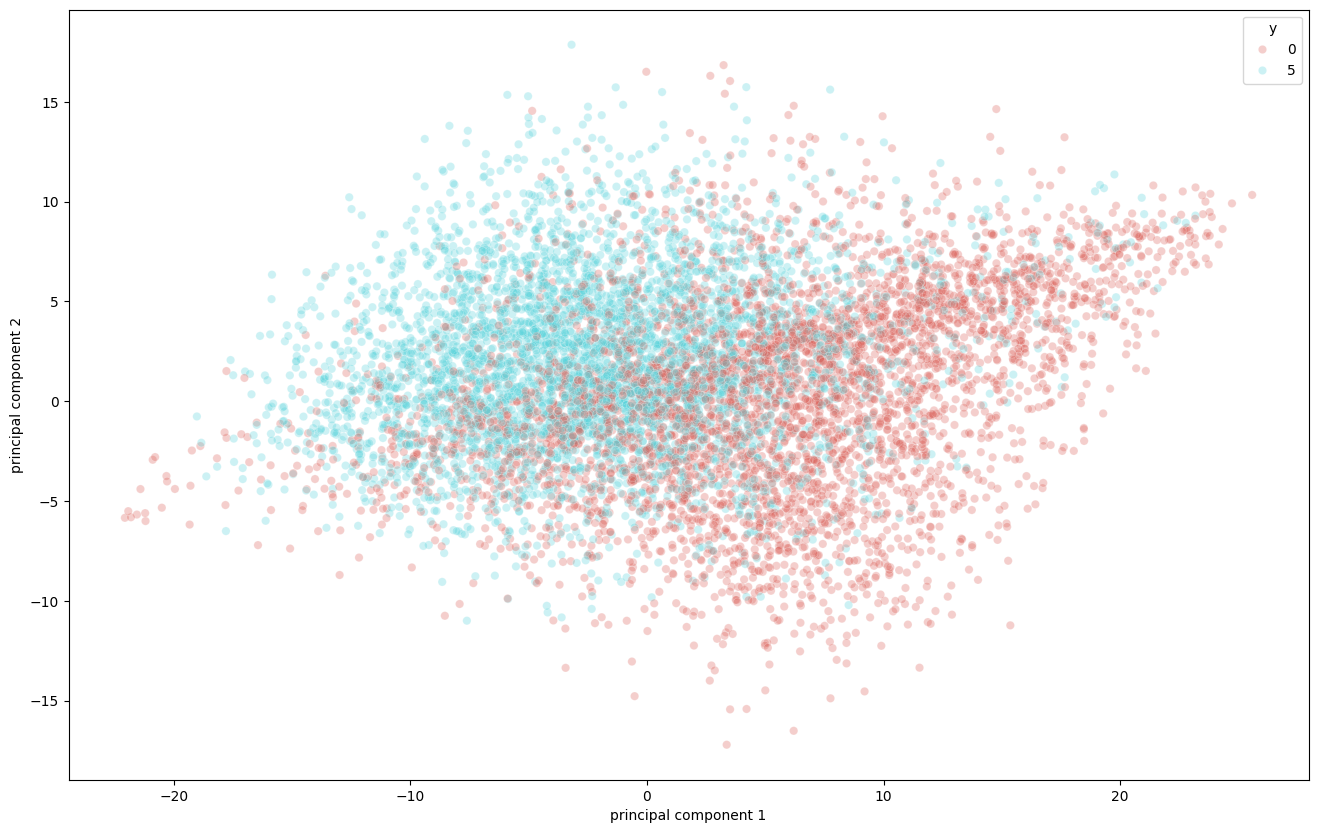

In [411]:
# Visualizzao schemi dei due DF ottenuti
print("Grafico distribuizione valori di TRAIN_filtrato")

print("")

import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df_filtrato_etichettato,
    legend="full",
    alpha=0.3
)

Grafico distribuizione valori di test_filtrato



<Axes: xlabel='principal component 1', ylabel='principal component 2'>

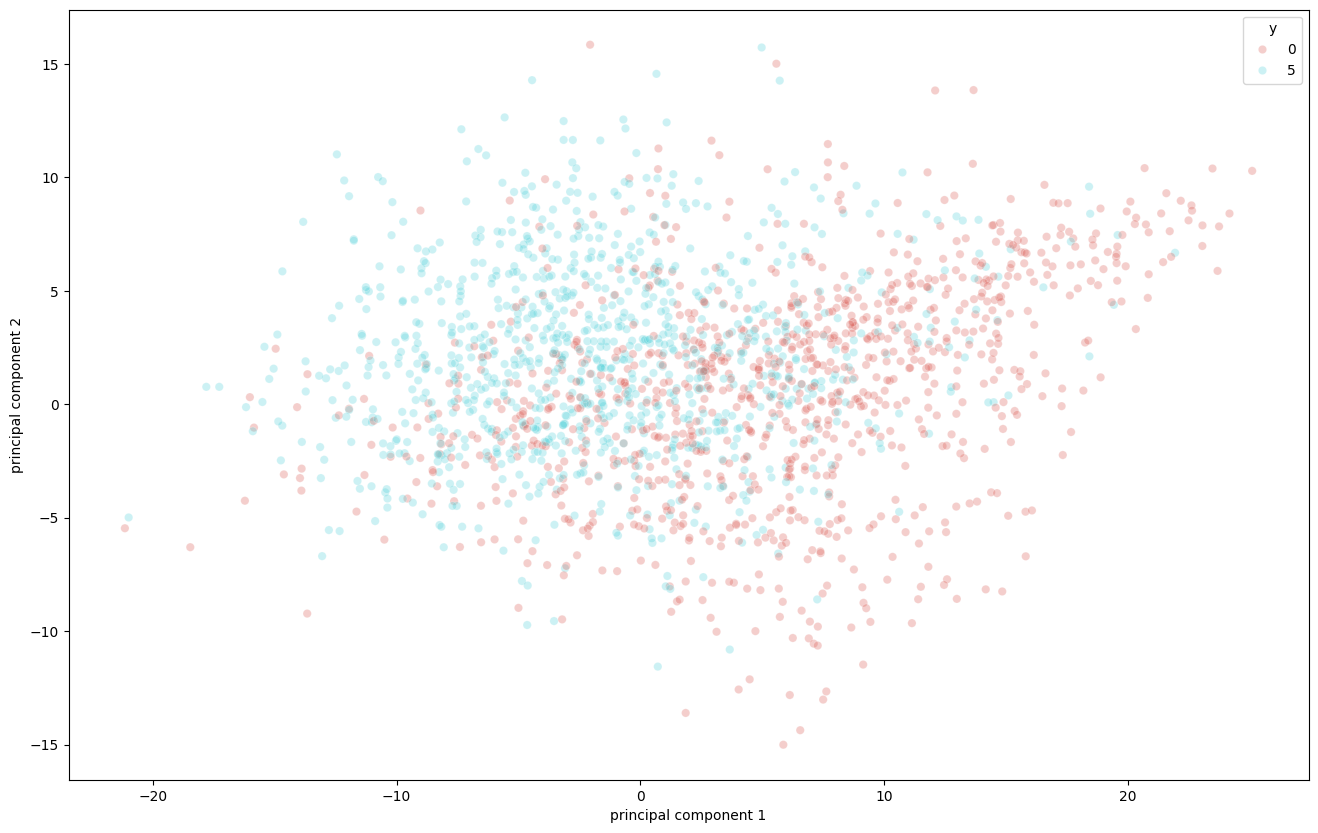

In [412]:
print("Grafico distribuizione valori di test_filtrato")

print("")

import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df_filtrato_etichettato_test,
    legend="full",
    alpha=0.3
)

Grafico distribuizione valori di val_filtrato



<Axes: xlabel='principal component 1', ylabel='principal component 2'>

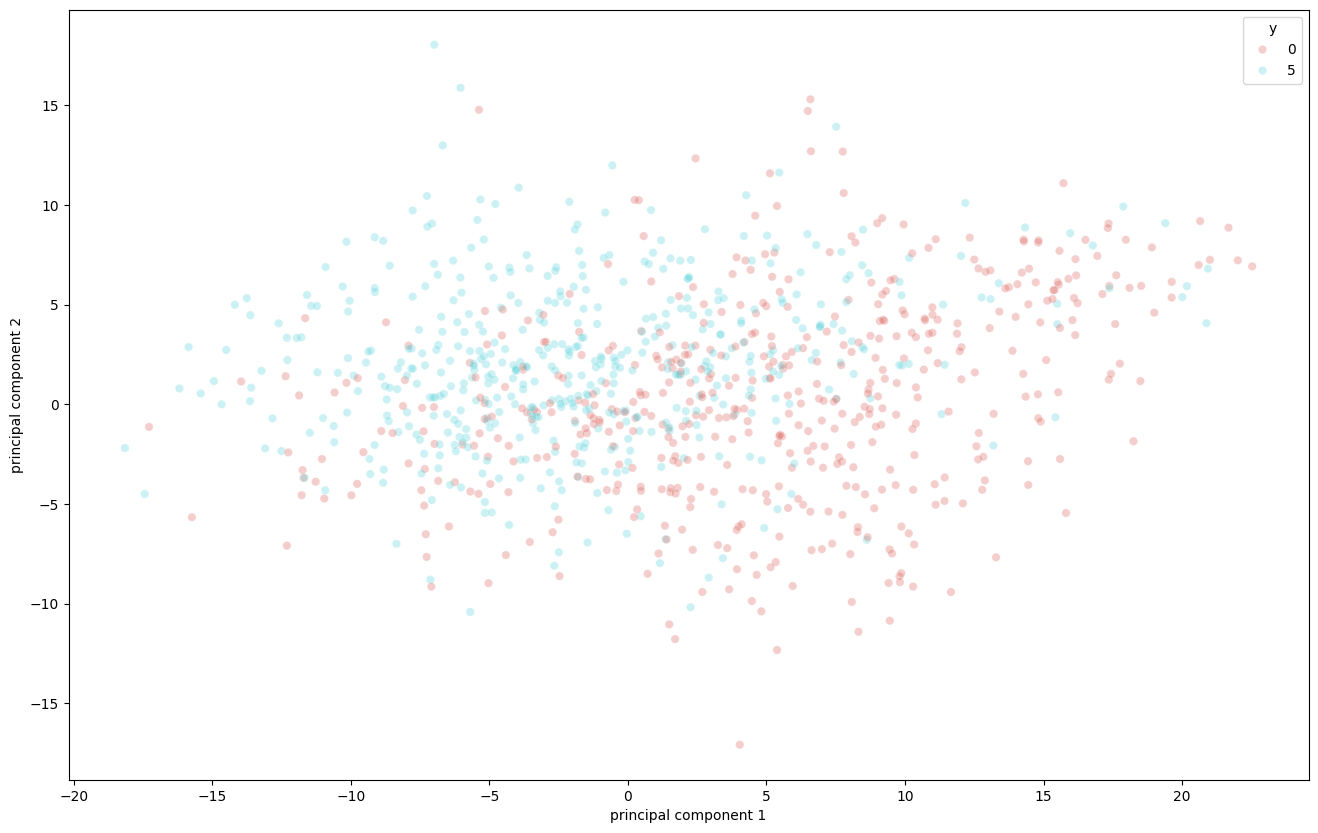

In [413]:
print("Grafico distribuizione valori di val_filtrato")

print("")

import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df_filtrato_etichettato_val,
    legend="full",
    alpha=0.3
)

In [ ]:
###################################################################################
### ORA alleno il modello nel distinguere con SVM solo i valori di classe 0 e 1 ###
###################################################################################

# - Inizio del lavoro con Support Vector Machine

# Import del modello di Support Vector Classifiers
from sklearn.svm import SVC

# Utilizzo di tuning automatico degli iperparametri tramite GridSearch
from sklearn.model_selection import GridSearchCV

In [ ]:
# METODO 1 - DIVISORE LINEARE

#############################################################################################
# - Ho inserito i dati di validazione per il training per testare con dataset più piccolo - #
#############################################################################################

# parameters for linear SVM
# - C è il parametro che regola fitting del modello, minore è meglio e meno adattato ai dati di training utilizzati
##parameters = {'C': [0.01,0.1,1,10,100,1000]}
parameters = {'C': [1000]}
linear_SVM = SVC(kernel='linear')

grid_linear=GridSearchCV(linear_SVM, parameters, cv=5)

# - Comando utile a trasformare le etichette nel formato desiderato
y_val_filtrato = y_val_filtrato.ravel()

# FITTING LINEAR KERNEL

grid_linear.fit(df_filtrato_val, y_val_filtrato)

print("Best score : " , grid_linear.best_score_)
print("Best parameters : " , grid_linear.best_params_)

KeyboardInterrupt: 

In [ ]:
# METODO 2 - KERNEL POLINOMIALE

# parameters for poly with degree 2 kernel
##  parameters = {'C': [100,10,1],'gamma':[0.01,0.1,1.], 'degree':[2,3]}
##  poly2_SVM = SVC(kernel='poly')

##  grid_poly=GridSearchCV(poly2_SVM, parameters, cv=5)
##  grid_poly.fit(df_filtrato_val, y_val_filtrato)

##  print ('\nRESULTS FOR POLY DEGREE KERNEL\n')

##  print("Best parameters set found:")
##  print(grid_poly.best_params_)

##  print("\nScore with best parameters:")
##  print(grid_poly.best_score_)


In [ ]:
# METODO 3 (Non finisce mai)

# parameters for rbf SVM

parameters = {'C': [1, 10, 100],'gamma':[0.01,0.1,1.]}

rbf_SVM = SVC(kernel='rbf')

grid_rbf=GridSearchCV(rbf_SVM, parameters, cv=5)
grid_rbf.fit(df_filtrato_val, y_val_filtrato)
print ('\nRESULTS FOR rbf KERNEL\n')

print("Best parameters set found:")
print(grid_rbf.best_params_)

print("\nScore with best parameters:")
print(grid_rbf.best_score_)


RESULTS FOR rbf KERNEL

Best parameters set found:
{'C': 100, 'gamma': 0.01}

Score with best parameters:
0.751743647271131


In [ ]:
# - Inizio del lavoro con Support Vector Machine

# Import del modello di Support Vector Classifiers
##  from sklearn.svm import SVC

# Utilizzo di tuning automatico degli iperparametri tramite GridSearch
##  from sklearn.model_selection import GridSearchCV

# METODO 1

# parameters for linear SVM
# - C è il parametro che regola fitting del modello, minore è meglio e meno adattato ai dati di training utilizzati
##  parameters = {'C': [0.01, 0.1, 1, 10, 100, 1000]}
##  linear_SVM = SVC(kernel='linear')

##  grid_linear=GridSearchCV(linear_SVM, parameters, cv=5)

# Tentativi vari di modifica delle dimensioni di y_train per fare si che andassero bene al SVM
#print(y_train.shape)
#y_train = y_train.reshape(-1,1)
#y_train = y_train.T
# - Comando utile a trasformare le etichette nel formato desiderato
##  y_train = y_train.ravel()
#print(y_train.shape)

#print(principal_cifar_Df.shape)
#print(principal_cifar_Df_con_etichette.shape)
#print(y_train.shape)

##grid_linear.fit(principal_cifar_Df, y_train)

##print("Best score : " , grid_linear.best_score_)
##print("Best parameters : " , grid_linear.best_params_)

# Sembra che SVM funzioni su dati di train trasformati in dataframe, devo convertire anche dati di test in DF per poter verificare il tutto

In [ ]:
# METODO 2 (Non finisce mai)

# parameters for poly with degree 2 kernel
#parameters = {'C': [1, 10, 100],'gamma':[0.01,0.1,1.], 'degree':[2,3]}
#poly2_SVM = SVC(kernel='poly')

#grid_poly=GridSearchCV(poly2_SVM, parameters, cv=5)
#grid_poly.fit(principal_cifar_Df, y_train)
#print ('\nRESULTS FOR POLY DEGREE KERNEL\n')

#print("Best parameters set found:")
#print(grid_poly.best_params_)

#print("\nScore with best parameters:")
#print(grid_poly.best_score_)



In [ ]:
# METODO 3 (Non finisce mai)

# parameters for rbf SVM

##  parameters = {'C': [1, 10, 100],'gamma':[0.01,0.1,1.]}

##  rbf_SVM = SVC(kernel='rbf')

##  grid_rbf=GridSearchCV(rbf_SVM, parameters, cv=5)
##  grid_rbf.fit(principal_cifar_Df, y_train)
##  print ('\nRESULTS FOR rbf KERNEL\n')

##  print("Best parameters set found:")
##  print(grid_rbf.best_params_)

##  print("\nScore with best parameters:")
##  print(grid_rbf.best_score_)

In [ ]:
# Seleziona del metodo migliore individuato

#get training and test error for the best SVM model from CV
##  best_SVM = SVC(C=0.01, kernel='linear')

# Allenamento del modello selezionato come migliore
##  best_SVM.fit(principal_cifar_Df, y_train)

# Manipolazione etichette test x compatibilità con metodo
##  y_test = y_test.ravel()

# Calcolo dell'errore come differenza tra 1 e la percentuale sul totale degli errori commessi
# - Errore nel training
##  training_error = 1. - best_SVM.score(principal_cifar_Df, y_train)
# - Errore nel test
##  test_error = 1. - best_SVM.score(principal_cifar_Df_test, y_test)

##  print ("Best SVM training error: %f" % training_error)
##  print ("Best SVM test error: %f" % test_error)

In [ ]:
# Prove di predizione con SVM
##predizioneSVM_test = best_SVM.predict(principal_cifar_Df_test)

##  print("Risultati predizione su valori di test : ")
##  print(predizioneSVM_test)

##  print("")

##  print("Etichette reali dei dati di test : ")
##  print(y_test)

##  print("")

##  print("Eseguo ciclo per confrontare uno a uno tutti i valori predetti con i valori reali : ")
##  c = 0
##  for i in range(len(y_test)):
##      if(predizioneSVM_test[i] != y_test[i]):
##          print(" -> Errore in posizione : " , i)
##          c=1
##  if(c == 0):
##     print(" -> Nessun errore")

# Funziona ? (Sembra di si)

In [ ]:
# Confronto delle predizioni
#confronto = predizioneSVM_test - predizioneRF_test

#print(" - Differenze tra le previsioni - ")
#print("Eseguo ciclo per confrontare uno a uno tutti i valori predetti con entrambi i metodi : ")
#c = 0
#for i in range(len(y_test)):
#    if(predizioneRF_test[i] != predizioneSVM_test[i]):
#        print(" -> Errore in posizione : " , i)
#        c=1
#if(c == 0):
#    print(" -> Nessun errore")

